In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import re

import nltk
from nltk.stem.porter import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords 
STOPWORDS = set(stopwords.words("english"))

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from wordcloud import WordCloud

In [3]:
df = pd.read_csv("./amazon_alexa.tsv", sep='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
for i in range(3):
    print(df['verified_reviews'].iloc[i],"\n")

Love my Echo! 

Loved it! 

Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. 



In [8]:
def custom_countplot(x, data, palette, figsize=None):
    
    if isinstance(figsize, tuple):
        plt.figure(figsize=figsize)
        
    sns.countplot(
        x=x,
        hue=x,
        data=data,
        palette=palette,
        legend=False,
        dodge=False
    )

    if figsize:
        plt.show()


In [9]:
def get_colours(name, values):
    cmap = plt.get_cmap(name, len(values))
    colours = [cmap(i) for i in range(len(values))]
    return colours

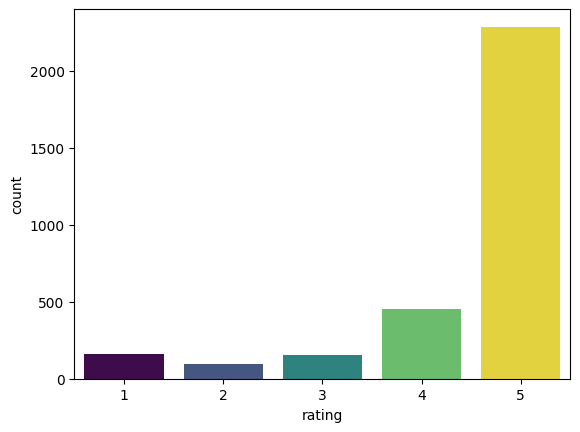

In [10]:
custom_countplot(x='rating', data=df, palette="viridis")

<Axes: ylabel='Percentage wise distrubution of rating'>

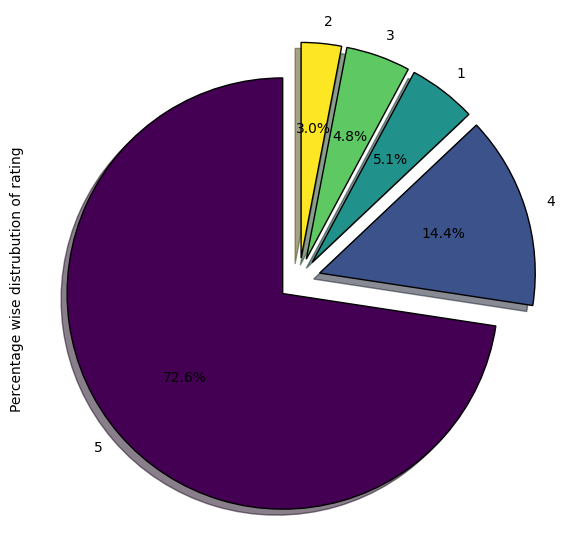

In [11]:
fig = plt.figure(figsize=(7,7))

wp = {'linewidth':1, "edgecolor":'black'}

tags = df['rating'].value_counts()/df.shape[0]

colors = get_colours('viridis', tags)

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

In [12]:
df['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

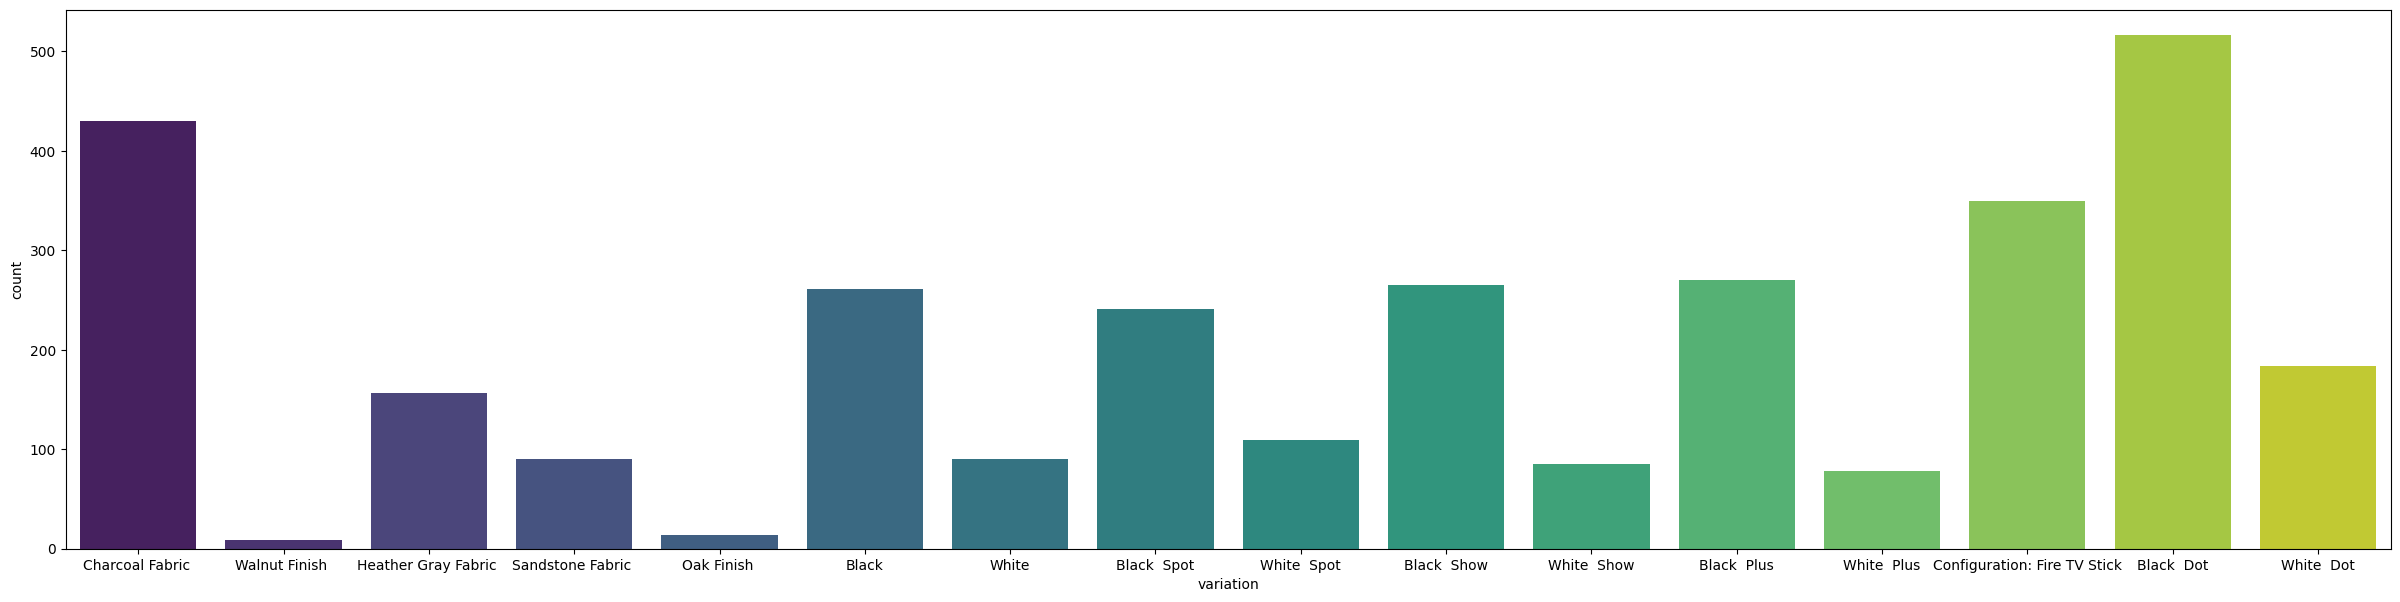

In [13]:
custom_countplot(x="variation", data=df, palette="viridis", figsize=(30,7))

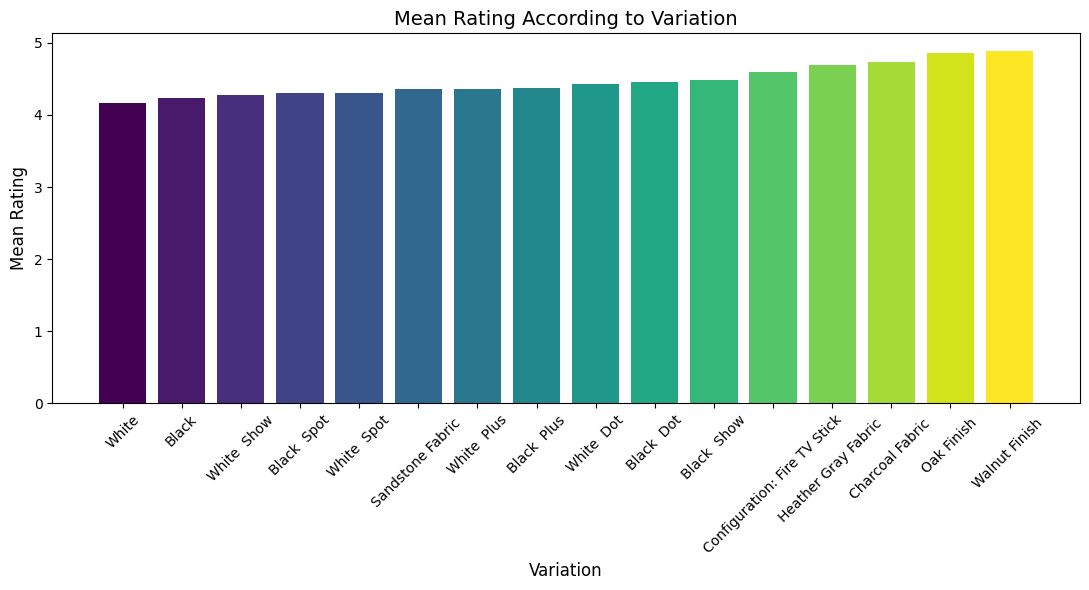

In [15]:
mean_ratings = df.groupby('variation')['rating'].mean().sort_values()

colors = get_colours('viridis', mean_ratings)

fig, ax = plt.subplots(figsize=(11, 6))
bars = ax.bar(mean_ratings.index, mean_ratings, color=colors)

ax.set_title("Mean Rating According to Variation", fontsize=14)
ax.set_xlabel("Variation", fontsize=12)
ax.set_ylabel("Mean Rating", fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

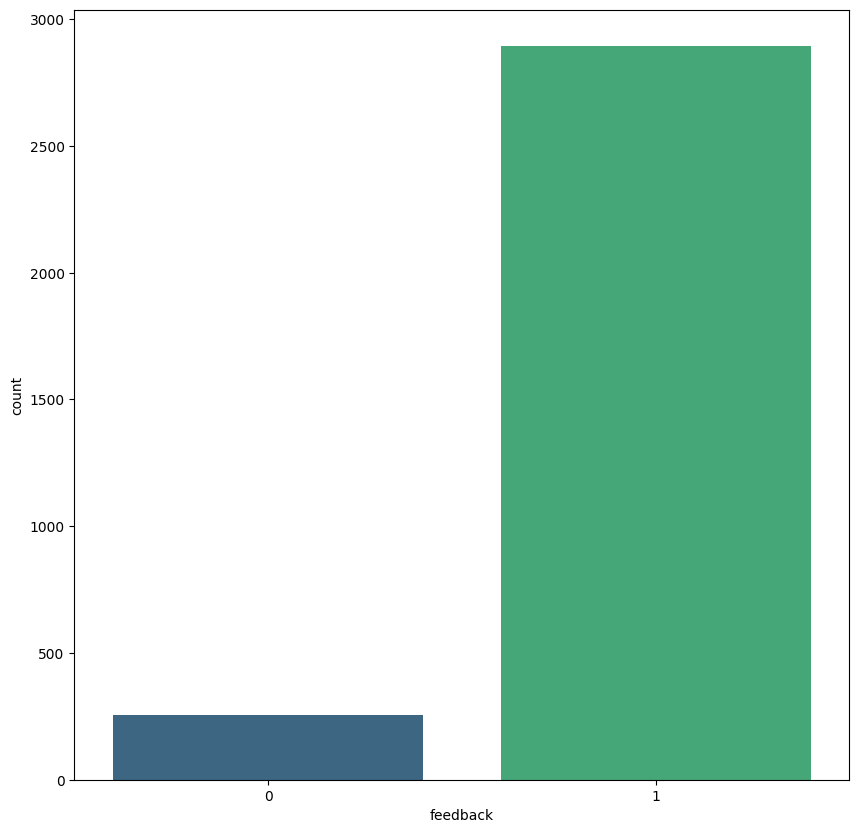

In [16]:
custom_countplot(x="feedback", data=df, palette="viridis", figsize=(10,10))

<Figure size 700x700 with 0 Axes>

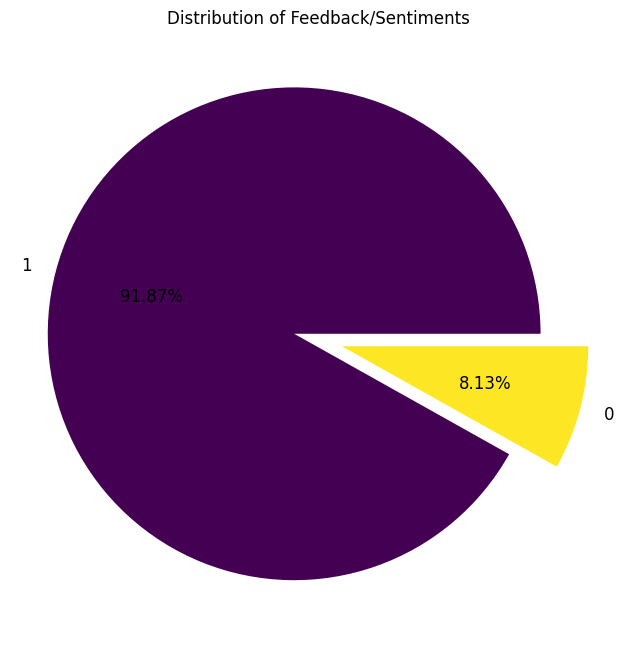

In [17]:
fig = plt.figure(figsize=(7,7))
vals = df['feedback'].value_counts()

colors = colors = get_colours('viridis', vals)
explode = (0.1, 0.1)

plt.figure(figsize=(8, 8))
plt.pie(vals, autopct='%1.2f%%', labels=vals.index, explode=explode, colors=colors, textprops={'fontsize': 12})
plt.title("Distribution of Feedback/Sentiments")
plt.show()

In [18]:
reviews =  " ".join([review for review in df['verified_reviews']])

In [19]:
def make_wordcloud(values, title, max_words):
    plt.figure(figsize=(20,15), facecolor='None')
    wc = WordCloud(max_words=max_words, width=1600, height=800).generate(values)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=19)
    plt.show()

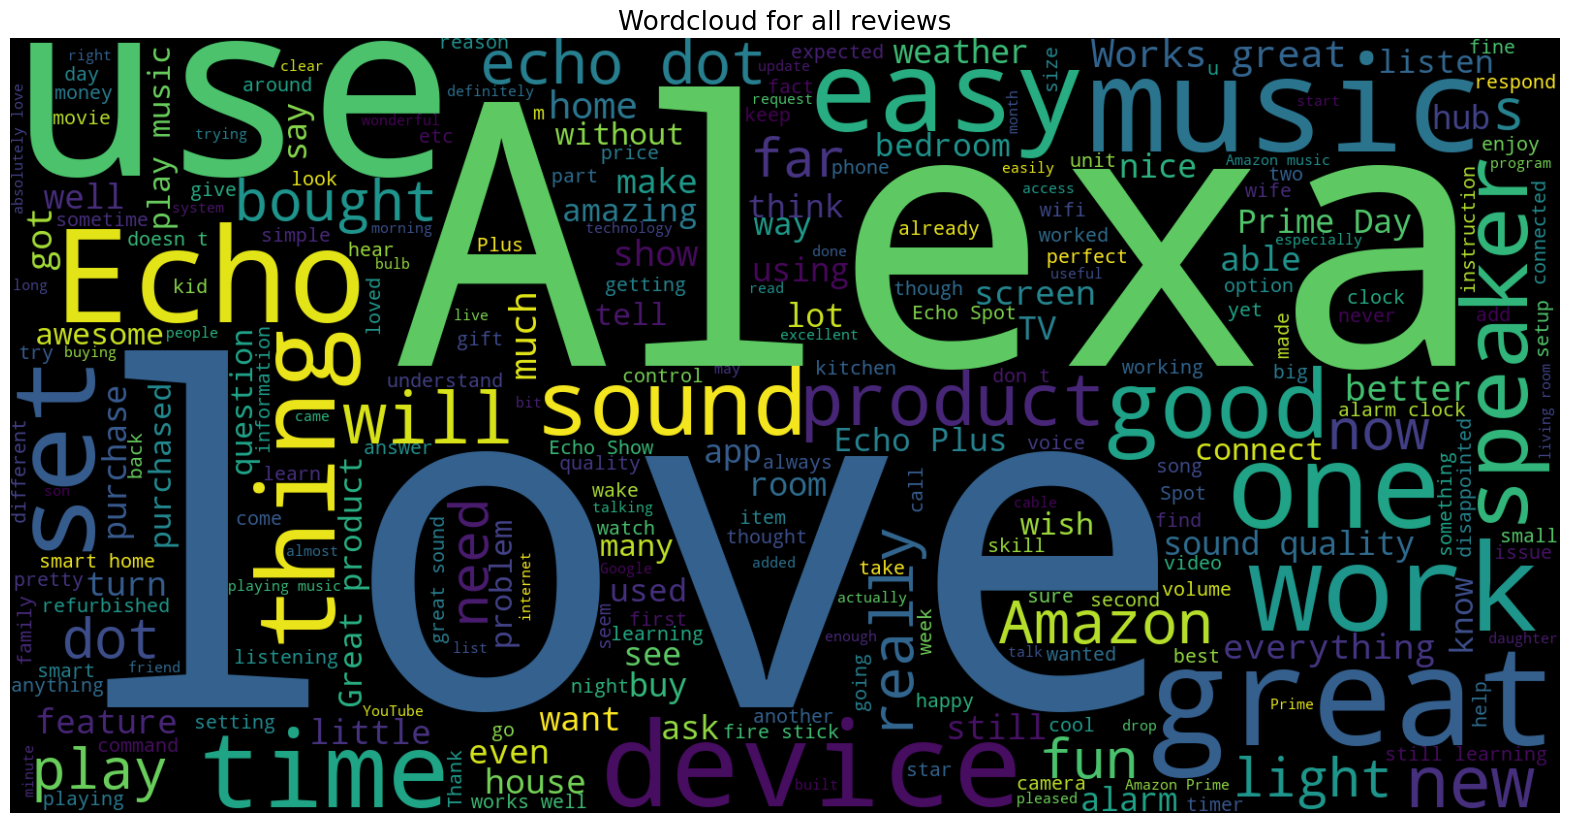

In [20]:
make_wordcloud(reviews, 'Wordcloud for all reviews', 250)

In [21]:
negative_reviews = " ".join([review for review in df[df['feedback'] == 0]['verified_reviews']]).lower().split()
positive_reviews = " ".join([review for review in df[df['feedback'] == 1]['verified_reviews']]).lower().split()

# remove overlapping words
unique_negatives = " ".join([x for x in negative_reviews if x not in positive_reviews])
unique_positives = " ".join([x for x in positive_reviews if x not in negative_reviews])

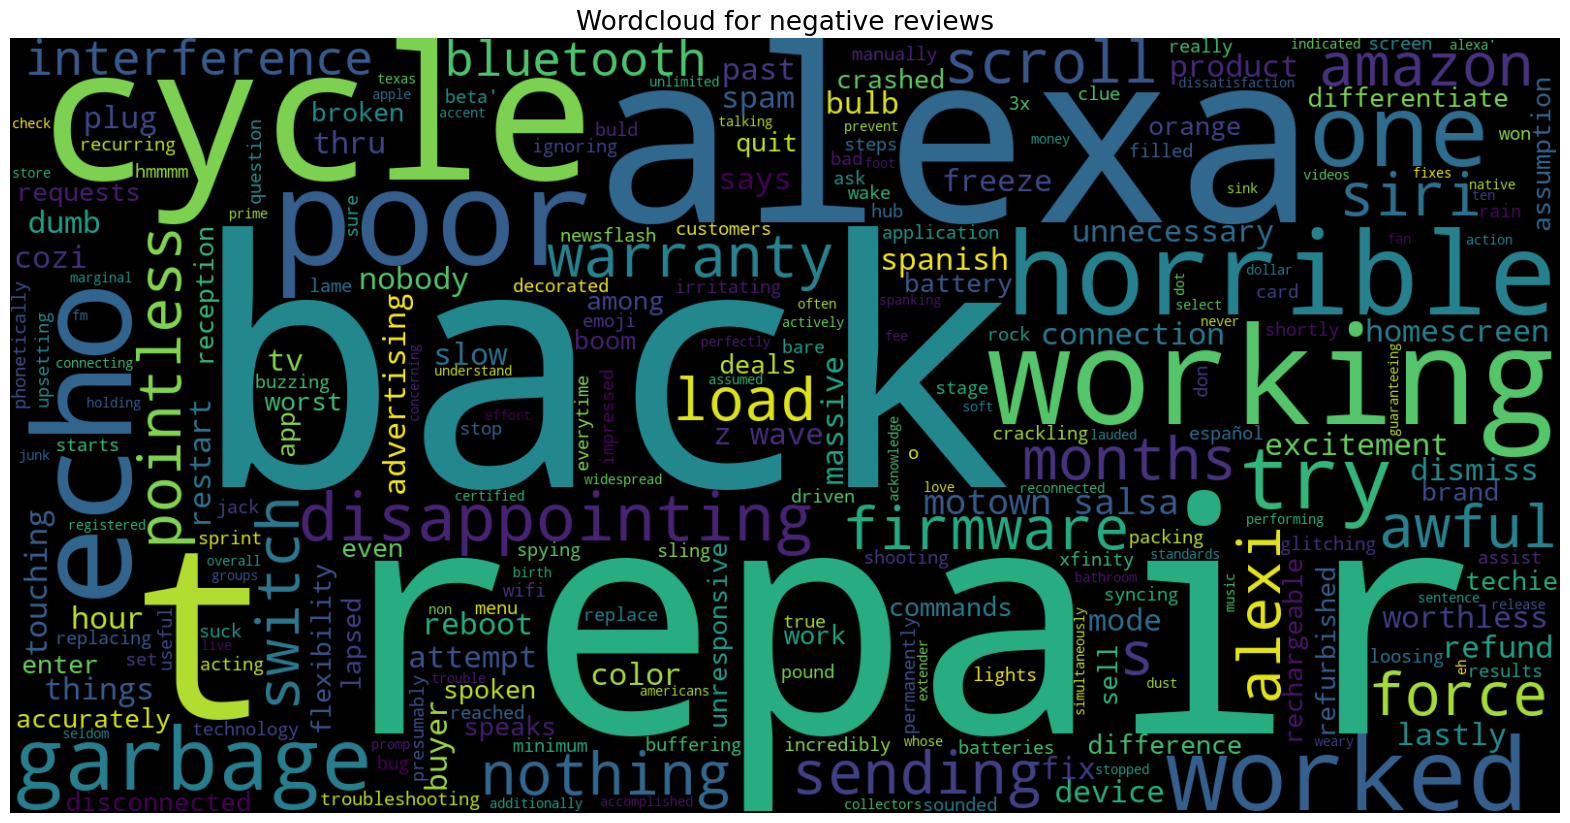

In [22]:
make_wordcloud(unique_negatives, 'Wordcloud for negative reviews', 250)

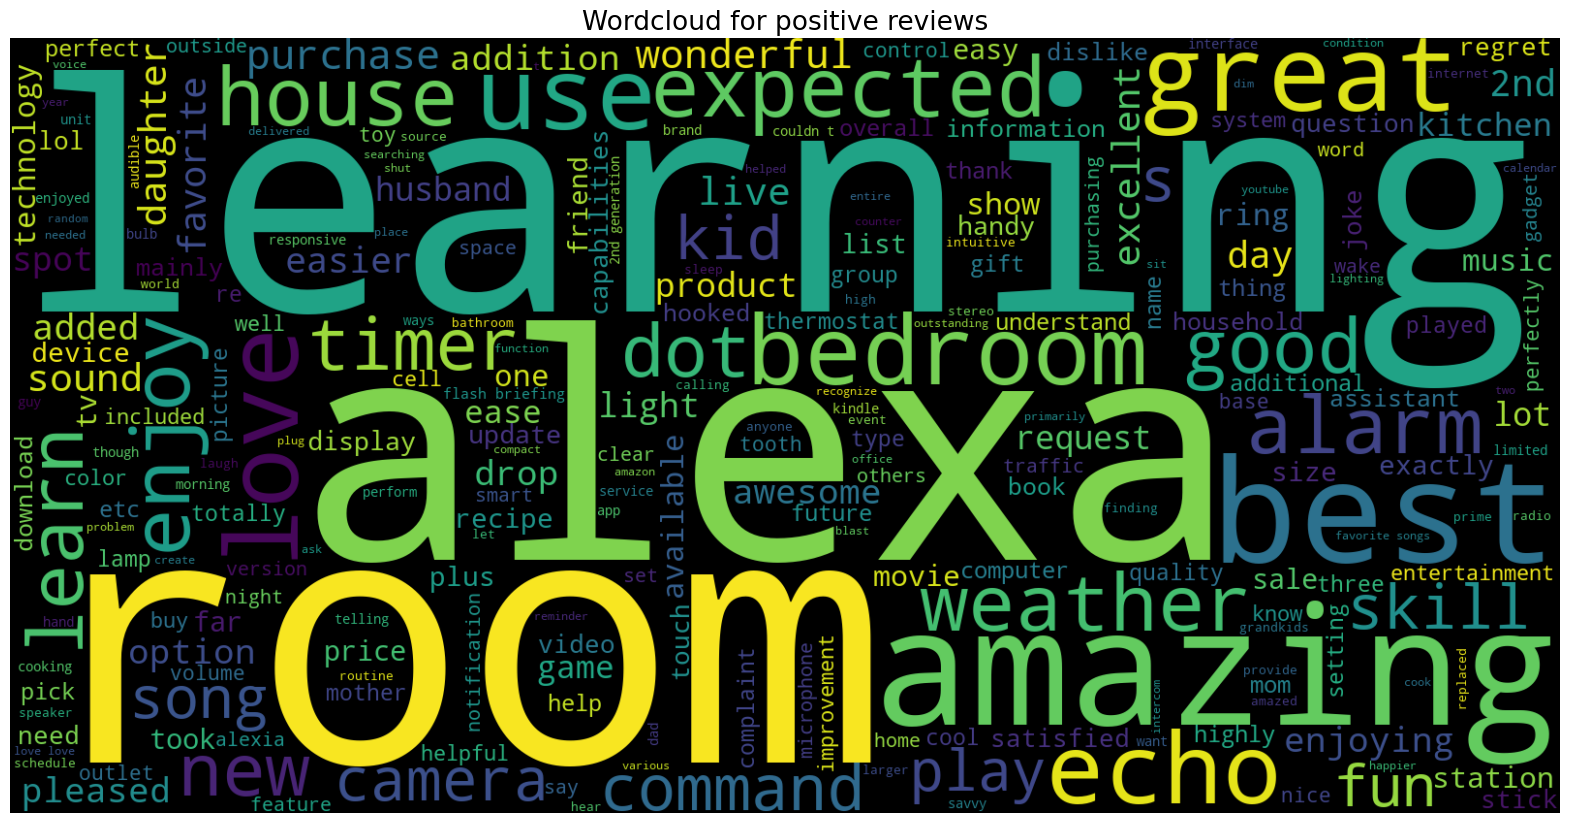

In [23]:
make_wordcloud(unique_positives, 'Wordcloud for positive reviews', 250)

# Model Initialization and Training 

In [24]:
cv = CountVectorizer(stop_words="english")
words = cv.fit_transform(df.verified_reviews)

In [25]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-z]', ' ', df.iloc[i]['verified_reviews']).lower().split()
    review = " ".join([stemmer.stem(word) for word in review if not word in STOPWORDS])
    corpus.append(review)

In [26]:
cv = CountVectorizer(max_features = 2500)

X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [32]:
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2519, 2500)
y train: (2519,)
X test: (630, 2500)
y test: (630,)


In [33]:
def k_fold_cross_val(model, X, y, cv): 
    results = cross_val_score(estimator = model, X = X, y = y, cv=cv)
    print(f'Standard Variance: {results.std():.6f}')
    print(f'Accuracy: {results.mean():.2f}')

In [34]:
def param_grid_search(model, X, y, n_splits):
    cv_obj = StratifiedKFold(n_splits = n_splits)
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = cv_obj, return_train_score = True, verbose = 0)
    grid_search.fit(X, y)

    print(f"Best Parameters: {grid_search.best_params_}")
    
    print(f"Training Accuracy: {grid_search.best_score_:.2f}")  
    
    model.set_params(**grid_search.best_params_)

In [36]:
def plot_confusion_matrix(preds, actuals, display_labels):
    cm = confusion_matrix(actuals, preds)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_disp.plot()
    plt.show()

In [136]:
rf = RandomForestClassifier()

In [138]:
params = {
    'max_depth': [50, 100],
    'n_estimators': [100, 200],
    'min_samples_split': [8, 12],
    "bootstrap": [True]
}

param_grid_search(rf, X_train, y_train, 2)

Best Parameters: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 200}
Training Accuracy: 0.93


In [175]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=12, n_estimators=200)

In [150]:
k_fold_cross_val(rf, X_train, y_train, 5)

Standard Variance: 0.003851
Accuracy: 0.93


In [146]:
y_preds = rf.predict(X_test)

In [147]:
test_accuracy = accuracy_score(y_test, y_preds)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.94


In [194]:
print("Classification Report:\n", classification_report(y_test, y_preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.28      0.42        50
           1       0.94      1.00      0.97       580

    accuracy                           0.94       630
   macro avg       0.91      0.64      0.70       630
weighted avg       0.94      0.94      0.93       630



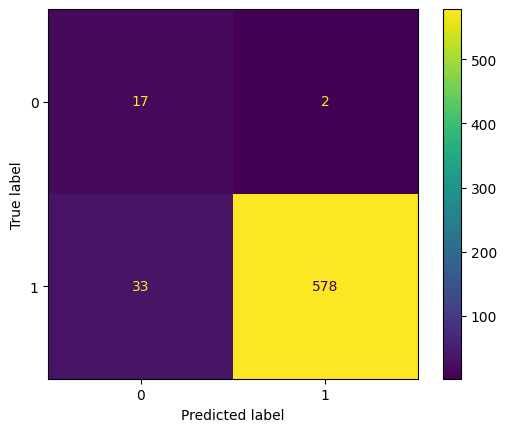

In [126]:
plot_confusion_matrix(y_test, y_preds, rf.classes_)

In [204]:
gb = GradientBoostingClassifier()

In [206]:
params = {
    'n_estimators': [200, 300],        
    'learning_rate': [0.05, 0.1],    
    'max_depth': [5],               
    'min_samples_split': [4, 8],      
    'min_samples_leaf': [2, 4]         
}

param_grid_search(gb, X_train, y_train, 2)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
Training Accuracy: 0.93


In [207]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                           min_samples_split=4, n_estimators=200)

In [208]:
k_fold_cross_val(gb, X_train, y_train, 5)

Standard Variance: 0.006393
Accuracy: 0.93


In [32]:
y_preds = gb.predict(X_test)

In [33]:
test_accuracy = accuracy_score(y_test, y_preds)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.96


In [34]:
print("Classification Report:\n", classification_report(y_test, y_preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.52      0.67        56
           1       0.95      1.00      0.98       574

    accuracy                           0.96       630
   macro avg       0.96      0.76      0.83       630
weighted avg       0.96      0.96      0.95       630



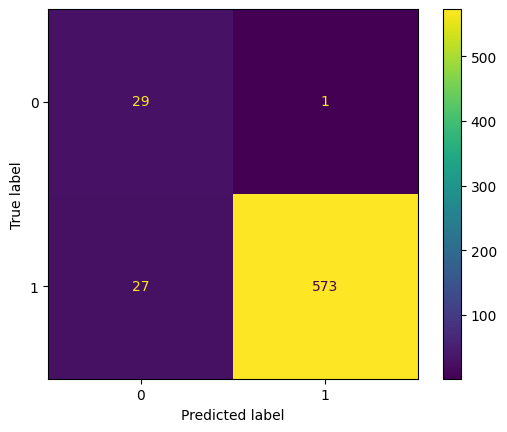

In [37]:
plot_confusion_matrix(y_test, y_preds, gb.classes_)

In [197]:
pickle.dump(gb, open('./gb_model.pkl', 'wb'))

In [196]:
pickle.dump(cv, open('./count_vectorizer.pkl', 'wb'))